# Analyzing League of Legends - Bot Lane Match Ups 

Carl Xiong

# Introduction

League of Legends is a MOBA (Massive Online Battle Arena) type game. It is a competitive game in which two teams of 10 players (5v5) battle it out. Each player selects their own unique champion and they have to work together with their team to battle against the enemy. There is not only a lot of skill involved, but also strategy as well. 

The premise of the game is simple. Players are placed into a map called summoners rift. Each player's respective champion can gain level by beating the game's monsters. By defeating the game control mobs, called creeps, their champions gain experience and gold. Experience allows the champion to level up and gold lets the champion purchase items from the shop. Levels and items will increase a champion stats such as health, attack damage, etc. The end object is to become more powerful than the opposing team's champions and to evantually defeat them by attacking their base, also called a Nexus in game. 

In my tutorial, I will go over some basic mechanics and patterns that have developed over the course of the game. I will be analyzing the win rates of certain champions compared to others and dissecting this reasoning. The game has developed a META, which means the game within the game. A more direct way of explaining it is "Most Effective Tactic Available." This means that a majority of the players will follow these specific set of guidelines because they yield the most results, in this case, wins for the game.

The game is set up as a 5v5 game but each of the players in the 5 man group all play a different way. Usually each player plays a unique lane or role in this case. The most widely accepted roles are Top, Jungle, Mid, Bot, and Support. For my tutorial I will be analyzing the Bot role and their respective dynamics. 

# Step 1 : Collecting the data.

Before we start analyzing anything, we have to find data to analyze. In my case, I will be using a dataset provide by Kaggle. This data set is provided in the from of a csv, or comma separated value. This file is useful for transfering data in table form, that is, each "cell" in a table, like an excel sheet, is separated by a comma. This is useful when transfering data from different sources or interpreters, like excel to google sheets.

The link for the data can be found in the link below. It is called games.csv
https://www.kaggle.com/jaytegge/league-of-legends-data-analysis/data

To begin processing it, we will have to use some python libraries, namely pandas and numpy.

In [429]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import warnings
warnings.filterwarnings('ignore')

We will use pandas' built in read csv function in order to read the csv file into a pandas' dataframe.

In [21]:
games = pd.read_csv("games.csv")
games.head()

,gameId,creationTime,gameDuration,seasonId,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,...,t2_towerKills,t2_inhibitorKills,t2_baronKills,t2_dragonKills,t2_riftHeraldKills,t2_ban1,t2_ban2,t2_ban3,t2_ban4,t2_ban5
0,3326086514,1504279457970,1949,9,1,2,1,1,1,1,...,5,0,0,1,1,114,67,43,16,51
1,3229566029,1497848803862,1851,9,1,1,1,1,0,1,...,2,0,0,0,0,11,67,238,51,420
2,3327363504,1504360103310,1493,9,1,2,1,1,1,2,...,2,0,0,1,0,157,238,121,57,28
3,3326856598,1504348503996,1758,9,1,1,1,1,1,1,...,0,0,0,0,0,164,18,141,40,51
4,3330080762,1504554410899,2094,9,1,2,1,1,1,1,...,3,0,0,1,0,86,11,201,122,18


In the above dataframe table, we have multiple rows and columns. Each row corresponds to a different game and the columns correspond to the statistics of that particular game such as duration (in seconds), winner (team 1 or team 2), the amount of objectives taken in each game by each team, towerKills, inhibitor kills, etc. The table also contains the champion IDs for each team. I will be analyzing this section in particular in order to come up with a conclusion about the underlying mechanics between each Top lane match up.

I'm mainly concerned with the win rates between the matchups of each champion, so lets only focus on those specific columns.

# Step 2 : Data Cleaning

Now that we have the usable data in a dataframe, we have to tidy it up so that it will be easier to focus on the important columns. For my particular analysis, I will be focusing on the win rates of the top lane champions. So the columns and variables that I will need are mainly going to be the winning team, and the individual champion IDs of each team.

Down below, I simply take a slice of the above dataframe with only the relevant columns.

In [132]:
wins = games[['winner','t1_champ1id','t1_champ2id','t1_champ3id','t1_champ4id','t1_champ5id','t2_champ1id','t2_champ2id','t2_champ3id','t2_champ4id','t2_champ5id']]
wins.head()

,winner,t1_champ1id,t1_champ2id,t1_champ3id,t1_champ4id,t1_champ5id,t2_champ1id,t2_champ2id,t2_champ3id,t2_champ4id,t2_champ5id
0,1,8,432,96,11,112,104,498,122,238,412
1,1,119,39,76,10,35,54,25,120,157,92
2,1,18,141,267,68,38,69,412,126,24,22
3,1,57,63,29,61,36,90,19,412,92,22
4,1,19,29,40,119,134,37,59,141,38,51


The table above shows the winner of each game, whether it was team 1 or team 2. The champion Ids are also shown above. However, it is not very intuitive to look at the data this way so lets try to match the champion IDs with their respective names. Thankfully in the dataset provided by Kaggle, they also list a json file which contains exactly that.

In [9]:
jDict = pd.read_json('champion_info.json')
champInfo = pd.read_json((jDict['data']).to_json(), orient='index')
champInfo.head()

,id,key,name,title
1,1,Annie,Annie,the Dark Child
10,10,Kayle,Kayle,The Judicator
101,101,Xerath,Xerath,the Magus Ascendant
102,102,Shyvana,Shyvana,the Half-Dragon
103,103,Ahri,Ahri,the Nine-Tailed Fox


If we wanted to get the name of Champion Id 119, this is how we would go about doing so.

In [41]:
id = 119
champInfo.loc[119,'key']

'Draven'

Now we have a table correlating the champion IDs with their names. I will save this part for last because it is very computationally intensive. The next part is focusing on the win rates. I can simply sum up the amount of times a particular champion won or lost to another and use that as the win percentage. I will represent this win data as a 2D matrix.

I will create 2 tables, one to record the wins and one to record the losses. At the end of the tallying, I can divide the win by the loss to get a win ratio for each champion against another champion.

The size of these win/loss tables will be the amount of champions currently in the game.

In [337]:
champList = (champInfo.loc[:,"id"])
champions = [0]
winRatio = pd.DataFrame(columns=champList)
winRatio['champions'] = champList.values
#winRatio.rename(index=str, columns={"Annie": "Champion", "champions": "Annie"})
#winRatio['Champion'] = winRatio['Annie']
winRatio.head()

id,1,10,101,102,103,104,105,106,107,11,...,86,89,9,90,91,92,96,98,99,champions
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,101
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,103


Setting all the values to 0

In [338]:
i = 0
j = 0
while i < len(winRatio.index):
    j = 0
    while j < len(winRatio.index):
        winRatio.iloc[i,j] = 0
        j += 1
    i +=1
    

Now we have a 2x2 Matrix that represeents every champion ID. Next I will create a copy of this array for the losses and a third copy for the final win percentage.

In [339]:
lossRatio = winRatio.copy()
finalRatio = winRatio.copy()

In [341]:
winRatio.head()

id,1,10,101,102,103,104,105,106,107,11,...,86,89,9,90,91,92,96,98,99,champions
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,101
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,102
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,103


In [342]:
lossRatio.head()

id,1,10,101,102,103,104,105,106,107,11,...,86,89,9,90,91,92,96,98,99,champions
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,101
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,102
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,103


Now I will being tallying up the wins and losses for each champion against another champion

In [297]:
temp = winRatio.loc[winRatio['champions'] == 101]
id = temp.index
winRatio.loc[id, 10] +=1

In [325]:
winRatio.loc[122,104]

0

NOTE: The dataset contains around 59,000 matches. I am only going to review the first 10,000 matches because it took a lot of time to iterate over all the values. However, if you had more time, one could feasibly record all wins for each champion tally up the total.

In [343]:
i = 0
#while i < len(wins.index):
while i < 10000:
    j = 1
    winTeam = wins.iloc[i,0]
    if winTeam == 1:
        j = 1
        while j < 6:
            currID = wins.iloc[i,j]
            won1 = wins.iloc[i,6]
            won2 = wins.iloc[i,7]
            won3 = wins.iloc[i,8]
            won4 = wins.iloc[i,9]
            won5 = wins.iloc[i,10]
            temp = winRatio.loc[winRatio['champions'] == currID]
            id = temp.index.tolist()[0]
            winRatio.loc[id,won1] += 1
            winRatio.loc[id,won2] += 1
            winRatio.loc[id,won3] += 1
            winRatio.loc[id,won4] += 1
            winRatio.loc[id,won5] += 1
            j += 1
        j = 6
        while j < 11:
            currID = wins.iloc[i,j]
            loss1 = wins.iloc[i,1]
            loss2 = wins.iloc[i,2]
            loss3 = wins.iloc[i,3]
            loss4 = wins.iloc[i,4]
            loss5 = wins.iloc[i,5]
            temp = winRatio.loc[winRatio['champions'] == currID]
            id = temp.index.tolist()[0]
            lossRatio.loc[id,loss1] += 1
            lossRatio.loc[id,loss2] += 1
            lossRatio.loc[id,loss3] += 1
            lossRatio.loc[id,loss4] += 1
            lossRatio.loc[id,loss5] += 1
            j += 1
            
    elif winTeam == 2:
        j = 6
        while j < 11:
            currID = wins.iloc[i,j]
            won1 = wins.iloc[i,1]
            won2 = wins.iloc[i,2]
            won3 = wins.iloc[i,3]
            won4 = wins.iloc[i,4]
            won5 = wins.iloc[i,5]
            temp = winRatio.loc[winRatio['champions'] == currID]
            id = temp.index.tolist()[0]
            winRatio.loc[id,won1] += 1
            winRatio.loc[id,won2] += 1
            winRatio.loc[id,won3] += 1
            winRatio.loc[id,won4] += 1
            winRatio.loc[id,won5] += 1
            j += 1
        j = 1
        while j < 6:
            currID = wins.iloc[i,j]
            loss1 = wins.iloc[i,6]
            loss2 = wins.iloc[i,7]
            loss3 = wins.iloc[i,8]
            loss4 = wins.iloc[i,9]
            loss5 = wins.iloc[i,10]
            temp = winRatio.loc[winRatio['champions'] == currID]
            id = temp.index.tolist()[0]
            lossRatio.loc[id,loss1] += 1
            lossRatio.loc[id,loss2] += 1
            lossRatio.loc[id,loss3] += 1
            lossRatio.loc[id,loss4] += 1
            lossRatio.loc[id,loss5] += 1
            j += 1            
    i += 1
            


In [344]:
winRatio.head()

id,1,10,101,102,103,104,105,106,107,11,...,86,89,9,90,91,92,96,98,99,champions
0,0,10,4,3,25,5,10,3,9,28,...,9,13,5,14,11,21,8,10,23,1
1,2,0,2,6,11,0,5,0,6,10,...,11,12,2,10,6,11,7,5,14,10
2,4,2,0,5,18,3,10,2,6,9,...,2,9,0,8,6,6,9,5,20,101
3,10,2,3,0,17,4,10,3,8,17,...,8,10,1,9,9,14,9,8,18,102
4,18,14,7,22,0,5,16,10,13,41,...,27,21,8,17,22,38,16,19,47,103


This is an example out of what the win matrix should look like. It is read such that the value in each cell is the number of wins a specific champion on the row index has on a champion on the column identifier. So take for example on the first row, third column, the value is 4. This means that championID 1 has won 4 games against championID 101.

In [345]:
lossRatio.head()

id,1,10,101,102,103,104,105,106,107,11,...,86,89,9,90,91,92,96,98,99,champions
0,0,2,4,10,18,5,8,4,9,16,...,13,20,5,14,11,17,14,6,31,1
1,10,0,2,2,14,5,5,0,4,14,...,7,8,1,5,7,16,6,8,9,10
2,4,2,0,3,7,2,6,1,2,6,...,9,7,2,7,3,8,3,1,12,101
3,3,6,5,0,22,3,7,2,10,17,...,8,12,3,6,10,12,9,3,18,102
4,25,11,18,17,0,5,28,8,10,20,...,19,28,13,26,17,30,13,16,46,103


This is the example of the loss ratio matrix. You will notice that it is an exact mirror/transpose of the win matrix. This makes sense because if a champion on the row wins against a champion on the column, then the column on the column will have a loss against the champion on the row. 

Interpreting this matrix is the same. If we look at the first row, third column, the value is 4. This means that championID 1 has also loss 4 games against championID 101. This means that the champion has loss the same number of games as it has won against the respective champion. 

So calculating the final win chance a certain champion has against another we use this formula.

winChance = winRatio/(winRatio + lossRatio)

We iterate over the both of the matrixes to calculate this value and store it in the finalRatio dataframe.

In [348]:
i = 0
while i < len(winRatio):
    j = 0
    while j < len(winRatio):
        winTemp = winRatio.iloc[i,j]
        lossTemp = lossRatio.iloc[i,j]
        finalRatio.iloc[i,j] = winTemp / (winTemp + lossTemp)
        j += 1
    i += 1

In [349]:
finalRatio

id,1,10,101,102,103,104,105,106,107,11,...,86,89,9,90,91,92,96,98,99,champions
0,NaN,0.833333,0.500000,0.230769,0.581395,0.500000,0.555556,0.428571,0.500000,0.636364,...,0.409091,0.393939,0.500000,0.500000,0.500000,0.552632,0.363636,0.625000,0.425926,1
1,0.166667,NaN,0.500000,0.750000,0.440000,0.000000,0.500000,NaN,0.600000,0.416667,...,0.611111,0.600000,0.666667,0.666667,0.461538,0.407407,0.538462,0.384615,0.608696,10
2,0.500000,0.500000,NaN,0.625000,0.720000,0.600000,0.625000,0.666667,0.750000,0.600000,...,0.181818,0.562500,0.000000,0.533333,0.666667,0.428571,0.750000,0.833333,0.625000,101
3,0.769231,0.250000,0.375000,NaN,0.435897,0.571429,0.588235,0.600000,0.444444,0.500000,...,0.500000,0.454545,0.250000,0.600000,0.473684,0.538462,0.500000,0.727273,0.500000,102
4,0.418605,0.560000,0.280000,0.564103,NaN,0.500000,0.363636,0.555556,0.565217,0.672131,...,0.586957,0.428571,0.380952,0.395349,0.564103,0.558824,0.551724,0.542857,0.505376,103
5,0.500000,1.000000,0.400000,0.428571,0.500000,NaN,0.800000,0.500000,0.333333,0.384615,...,0.500000,0.333333,0.666667,0.500000,0.583333,0.611111,0.500000,0.363636,0.400000,104
6,0.444444,0.500000,0.375000,0.411765,0.636364,0.200000,NaN,0.200000,0.555556,0.541667,...,0.391304,0.404762,0.428571,0.529412,0.450000,0.567568,0.500000,0.565217,0.518519,105
7,0.571429,NaN,0.333333,0.400000,0.444444,0.500000,0.800000,NaN,0.500000,0.500000,...,0.555556,0.750000,0.250000,0.375000,0.400000,0.666667,0.285714,0.625000,0.523810,106
8,0.500000,0.400000,0.250000,0.555556,0.434783,0.666667,0.444444,0.500000,NaN,0.384615,...,0.437500,0.523810,0.428571,0.538462,0.466667,0.470588,0.800000,0.611111,0.500000,107
9,0.363636,0.583333,0.400000,0.500000,0.327869,0.615385,0.458333,0.500000,0.615385,NaN,...,0.490566,0.367647,0.421053,0.441860,0.514286,0.470588,0.483871,0.451613,0.637500,11


Here we have a bit of a problem. Some of the values are NaN values. This is because we are attempting a division by 0. There are two cases in which this happens. One is along the diagonal, which makes sense because in the game, once a champion has been picked or selected by one side, the opposing team cannot choose the same champion. The other case is if a particular champion has not loss yet. This means that the win chance is 100%. So I will have to make a slight modification in the code and check for a division by 0 error.

In [350]:
i = 0
while i < len(winRatio):
    j = 0
    while j < len(winRatio):
        winTemp = winRatio.iloc[i,j]
        lossTemp = lossRatio.iloc[i,j]
        if lossTemp == 0:
            finalRatio.iloc[i,j] = 1
        else:
            finalRatio.iloc[i,j] = winTemp / (winTemp + lossTemp)
        j += 1
    i += 1

I simply added an if statement that checked if there was a division by 0. If there was, then simply set the win percentage to a 100%, in our case, we use floating points from 0 to 1 to represent the percentages so 100% would equate to 1.

In [351]:
finalRatio

id,1,10,101,102,103,104,105,106,107,11,...,86,89,9,90,91,92,96,98,99,champions
0,1.000000,0.833333,0.500000,0.230769,0.581395,0.500000,0.555556,0.428571,0.500000,0.636364,...,0.409091,0.393939,0.500000,0.500000,0.500000,0.552632,0.363636,0.625000,0.425926,1
1,0.166667,1.000000,0.500000,0.750000,0.440000,0.000000,0.500000,1.000000,0.600000,0.416667,...,0.611111,0.600000,0.666667,0.666667,0.461538,0.407407,0.538462,0.384615,0.608696,10
2,0.500000,0.500000,1.000000,0.625000,0.720000,0.600000,0.625000,0.666667,0.750000,0.600000,...,0.181818,0.562500,0.000000,0.533333,0.666667,0.428571,0.750000,0.833333,0.625000,101
3,0.769231,0.250000,0.375000,1.000000,0.435897,0.571429,0.588235,0.600000,0.444444,0.500000,...,0.500000,0.454545,0.250000,0.600000,0.473684,0.538462,0.500000,0.727273,0.500000,102
4,0.418605,0.560000,0.280000,0.564103,1.000000,0.500000,0.363636,0.555556,0.565217,0.672131,...,0.586957,0.428571,0.380952,0.395349,0.564103,0.558824,0.551724,0.542857,0.505376,103
5,0.500000,1.000000,0.400000,0.428571,0.500000,1.000000,0.800000,0.500000,0.333333,0.384615,...,0.500000,0.333333,0.666667,0.500000,0.583333,0.611111,0.500000,0.363636,0.400000,104
6,0.444444,0.500000,0.375000,0.411765,0.636364,0.200000,1.000000,0.200000,0.555556,0.541667,...,0.391304,0.404762,0.428571,0.529412,0.450000,0.567568,0.500000,0.565217,0.518519,105
7,0.571429,1.000000,0.333333,0.400000,0.444444,0.500000,0.800000,1.000000,0.500000,0.500000,...,0.555556,0.750000,0.250000,0.375000,0.400000,0.666667,0.285714,0.625000,0.523810,106
8,0.500000,0.400000,0.250000,0.555556,0.434783,0.666667,0.444444,0.500000,1.000000,0.384615,...,0.437500,0.523810,0.428571,0.538462,0.466667,0.470588,0.800000,0.611111,0.500000,107
9,0.363636,0.583333,0.400000,0.500000,0.327869,0.615385,0.458333,0.500000,0.615385,1.000000,...,0.490566,0.367647,0.421053,0.441860,0.514286,0.470588,0.483871,0.451613,0.637500,11


# Step 3 : Visuallization

After cleaning the data, this step is for ease of use. This lets a un-informed reader intepret the data easily.

Below, I replace all the ugly champion IDs with their respective names so that we can get a better understanding of who is being picked into the game and how the matchups are.

In [393]:
finalRatio.head()

id,1,10,101,102,103,104,105,106,107,11,...,86,89,9,90,91,92,96,98,99,champions
0,1.000000,0.833333,0.500,0.230769,0.581395,0.500000,0.555556,0.428571,0.500000,0.636364,...,0.409091,0.393939,0.500000,0.500000,0.500000,0.552632,0.363636,0.625000,0.425926,1
1,0.166667,1.000000,0.500,0.750000,0.440000,0.000000,0.500000,1.000000,0.600000,0.416667,...,0.611111,0.600000,0.666667,0.666667,0.461538,0.407407,0.538462,0.384615,0.608696,10
2,0.500000,0.500000,1.000,0.625000,0.720000,0.600000,0.625000,0.666667,0.750000,0.600000,...,0.181818,0.562500,0.000000,0.533333,0.666667,0.428571,0.750000,0.833333,0.625000,101
3,0.769231,0.250000,0.375,1.000000,0.435897,0.571429,0.588235,0.600000,0.444444,0.500000,...,0.500000,0.454545,0.250000,0.600000,0.473684,0.538462,0.500000,0.727273,0.500000,102
4,0.418605,0.560000,0.280,0.564103,1.000000,0.500000,0.363636,0.555556,0.565217,0.672131,...,0.586957,0.428571,0.380952,0.395349,0.564103,0.558824,0.551724,0.542857,0.505376,103


In [418]:
idList = finalRatio.columns

i = 0
while i < len(idList) - 1:
    currId = idList[i]
    newname = champInfo.iloc[i].key
    finalRatio = finalRatio.rename(columns={currId: newname})
    i += 1

In [420]:
finalRatio.head()

id,Annie,Kayle,Xerath,Shyvana,Ahri,Graves,Fizz,Volibear,Rengar,MasterYi,...,Garen,Leona,Fiddlesticks,Malzahar,Talon,Riven,KogMaw,Shen,Lux,champions
0,1.000000,0.833333,0.500,0.230769,0.581395,0.500000,0.555556,0.428571,0.500000,0.636364,...,0.409091,0.393939,0.500000,0.500000,0.500000,0.552632,0.363636,0.625000,0.425926,1
1,0.166667,1.000000,0.500,0.750000,0.440000,0.000000,0.500000,1.000000,0.600000,0.416667,...,0.611111,0.600000,0.666667,0.666667,0.461538,0.407407,0.538462,0.384615,0.608696,10
2,0.500000,0.500000,1.000,0.625000,0.720000,0.600000,0.625000,0.666667,0.750000,0.600000,...,0.181818,0.562500,0.000000,0.533333,0.666667,0.428571,0.750000,0.833333,0.625000,101
3,0.769231,0.250000,0.375,1.000000,0.435897,0.571429,0.588235,0.600000,0.444444,0.500000,...,0.500000,0.454545,0.250000,0.600000,0.473684,0.538462,0.500000,0.727273,0.500000,102
4,0.418605,0.560000,0.280,0.564103,1.000000,0.500000,0.363636,0.555556,0.565217,0.672131,...,0.586957,0.428571,0.380952,0.395349,0.564103,0.558824,0.551724,0.542857,0.505376,103


Great, now that we have the column portion all converted into chammpion names, we need to do the same for the row portion.

In [427]:
i = 0
while i < len(finalRatio.index):
    finalRatio.iloc[i,138] = champInfo.iloc[i].key
    i += 1


In [428]:
finalRatio.head()

id,Annie,Kayle,Xerath,Shyvana,Ahri,Graves,Fizz,Volibear,Rengar,MasterYi,...,Garen,Leona,Fiddlesticks,Malzahar,Talon,Riven,KogMaw,Shen,Lux,champions
0,1.000000,0.833333,0.500,0.230769,0.581395,0.500000,0.555556,0.428571,0.500000,0.636364,...,0.409091,0.393939,0.500000,0.500000,0.500000,0.552632,0.363636,0.625000,0.425926,Annie
1,0.166667,1.000000,0.500,0.750000,0.440000,0.000000,0.500000,1.000000,0.600000,0.416667,...,0.611111,0.600000,0.666667,0.666667,0.461538,0.407407,0.538462,0.384615,0.608696,Kayle
2,0.500000,0.500000,1.000,0.625000,0.720000,0.600000,0.625000,0.666667,0.750000,0.600000,...,0.181818,0.562500,0.000000,0.533333,0.666667,0.428571,0.750000,0.833333,0.625000,Xerath
3,0.769231,0.250000,0.375,1.000000,0.435897,0.571429,0.588235,0.600000,0.444444,0.500000,...,0.500000,0.454545,0.250000,0.600000,0.473684,0.538462,0.500000,0.727273,0.500000,Shyvana
4,0.418605,0.560000,0.280,0.564103,1.000000,0.500000,0.363636,0.555556,0.565217,0.672131,...,0.586957,0.428571,0.380952,0.395349,0.564103,0.558824,0.551724,0.542857,0.505376,Ahri


Now we finally have a completed matrix correlating each champions win rates. One last step is to change the column for the champion names as a index.

In [433]:
finalRatio = finalRatio.set_index('champions')
finalRatio.head()

id,Annie,Kayle,Xerath,Shyvana,Ahri,Graves,Fizz,Volibear,Rengar,MasterYi,...,Kennen,Garen,Leona,Fiddlesticks,Malzahar,Talon,Riven,KogMaw,Shen,Lux
champions,,,,,,,,,,,,,,,,,,,,,
Annie,1.000000,0.833333,0.500,0.230769,0.581395,0.500000,0.555556,0.428571,0.500000,0.636364,...,0.428571,0.409091,0.393939,0.500000,0.500000,0.500000,0.552632,0.363636,0.625000,0.425926
Kayle,0.166667,1.000000,0.500,0.750000,0.440000,0.000000,0.500000,1.000000,0.600000,0.416667,...,0.600000,0.611111,0.600000,0.666667,0.666667,0.461538,0.407407,0.538462,0.384615,0.608696
Xerath,0.500000,0.500000,1.000,0.625000,0.720000,0.600000,0.625000,0.666667,0.750000,0.600000,...,1.000000,0.181818,0.562500,0.000000,0.533333,0.666667,0.428571,0.750000,0.833333,0.625000
Shyvana,0.769231,0.250000,0.375,1.000000,0.435897,0.571429,0.588235,0.600000,0.444444,0.500000,...,0.714286,0.500000,0.454545,0.250000,0.600000,0.473684,0.538462,0.500000,0.727273,0.500000
Ahri,0.418605,0.560000,0.280,0.564103,1.000000,0.500000,0.363636,0.555556,0.565217,0.672131,...,0.441176,0.586957,0.428571,0.380952,0.395349,0.564103,0.558824,0.551724,0.542857,0.505376


Now we can starting plotting using either matplotlib or seaborn.

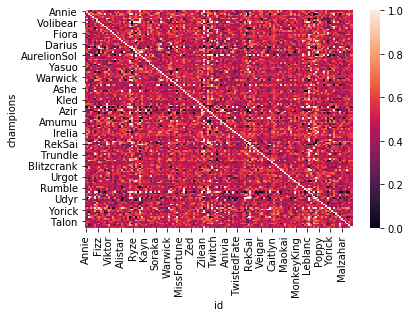

In [434]:
ax = sns.heatmap(finalRatio)

This contains a lot of data and is very difficult to analyze. I stated earlier that I would go over bot lane match ups so lets focus only on champions that are in the bottom lane. 

Now this is a difficult problem since the data set we were given does not contain what lane each player selected for their champion. However, we can infer that certain champions are more likely to be played in the botlane. Champions that are usually ranged based and fill the Marksman role are an adequate fit for laning in the bottom side of the map.

In order to try to estimate correctly whether or not a particular champion would be found in the bot lane, I'll simply use the tag role listed for each champion. These roles can be found on the in game client or through external sources like the community wiki or sites like champion.gg.

The following champions will be selected for the bot lane role:

Ashe, Caitlyn, Corki, Draven, Ezreal, Jhin, Jinx, Kai'Sa, Kalista, Kog'Maw, Lucian, Miss Fortune, Quinn, Sivir, Tristana, Twitch, Varus, Vayne, Xayah.

In [447]:
botRatio = finalRatio[["Ashe","Caitlyn","Corki","Draven","Ezreal","Jhin","Jinx","Kalista","KogMaw","Lucian","MissFortune","Quinn","Sivir","Tristana","Twitch","Varus","Vayne","Xayah"]]
botRatio.head()                      

id,Ashe,Caitlyn,Corki,Draven,Ezreal,Jhin,Jinx,Kalista,KogMaw,Lucian,MissFortune,Quinn,Sivir,Tristana,Twitch,Varus,Vayne,Xayah
champions,,,,,,,,,,,,,,,,,,
Annie,0.392857,0.526316,0.428571,0.541667,0.680000,0.571429,0.551724,0.454545,0.363636,0.490566,0.314815,0.583333,0.500000,0.453333,0.535714,0.428571,0.592593,0.560000
Kayle,0.434783,0.633333,0.666667,0.769231,0.722222,0.514286,0.300000,0.300000,0.538462,0.473684,0.428571,0.333333,0.666667,0.489796,0.482759,0.375000,0.512821,0.422222
Xerath,0.550000,0.461538,0.571429,0.384615,0.625000,0.588235,0.708333,0.650000,0.750000,0.500000,0.571429,0.750000,0.615385,0.432432,0.428571,1.000000,0.484848,0.590909
Shyvana,0.636364,0.651163,0.777778,0.592593,0.440000,0.630435,0.562500,0.461538,0.500000,0.625000,0.666667,0.636364,0.409091,0.428571,0.486486,0.500000,0.510204,0.472222
Ahri,0.586667,0.530120,0.666667,0.509804,0.540984,0.520548,0.468085,0.468085,0.551724,0.520833,0.405405,0.666667,0.547619,0.487013,0.529412,0.500000,0.560345,0.479592


In [453]:
botRatio = botRatio.loc[["Ashe","Caitlyn","Corki","Draven","Ezreal","Jhin","Jinx","Kalista","KogMaw","Lucian","MissFortune","Quinn","Sivir","Tristana","Twitch","Varus","Vayne","Xayah"]]
botRatio.head()

id,Ashe,Caitlyn,Corki,Draven,Ezreal,Jhin,Jinx,Kalista,KogMaw,Lucian,MissFortune,Quinn,Sivir,Tristana,Twitch,Varus,Vayne,Xayah
champions,,,,,,,,,,,,,,,,,,
Ashe,1.000000,0.480000,0.476190,0.418182,0.351852,0.516854,0.483871,0.431818,0.375000,0.400000,0.421875,0.400000,0.574468,0.442953,0.445652,0.342857,0.456000,0.439560
Caitlyn,0.520000,1.000000,0.606061,0.500000,0.483871,0.447154,0.496183,0.571429,0.282609,0.508621,0.453333,0.533333,0.511628,0.446429,0.408759,0.514286,0.437908,0.445652
Corki,0.523810,0.393939,1.000000,0.611111,0.615385,0.586207,0.444444,0.521739,0.333333,0.448980,0.485714,0.428571,0.400000,0.430556,0.365385,0.727273,0.403509,0.500000
Draven,0.581818,0.500000,0.388889,1.000000,0.511628,0.494118,0.544118,0.600000,0.320000,0.512500,0.553846,0.555556,0.612903,0.406897,0.465116,0.608696,0.489796,0.632353
Ezreal,0.648148,0.516129,0.384615,0.488372,1.000000,0.460526,0.471264,0.352941,0.481481,0.500000,0.554217,0.384615,0.404255,0.362069,0.438356,0.407407,0.410256,0.542056


Now we have limited our dataframe to only include data from the Marksman champions. Lets try to plot our heatmap again.

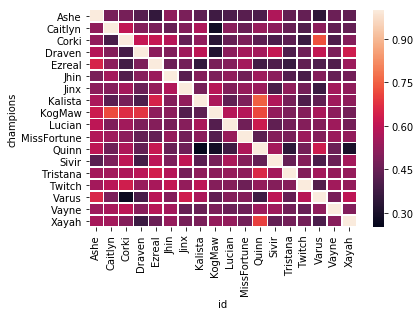

In [455]:
ax = sns.heatmap(botRatio,linewidths=.5)

# Step 4 : Conclusion

This heat map is a lot better and can tell us way more about a champion's particular matchup. Overall, the graph seems mostly uniformly distributed. However, there are some notable features. 

This graph shows the win rates of every champion that has been classified as a Marksman by the game. We can interpret this graph in many ways. If a particular row has a lot of dark, almost black, boxes, that means that specific champion has lost a lot of games to the champions on the column. 

Take for example Quinn. Quinn has multiple, dark shaded boxes, along her win rate row. Notably, Quinn has lost a lot of games to Kalista, KogMaw, Tristana, and Xayah.

On the other hand, KogMaw has many brightly colored boxes. This signifies that he is a strong matchup to many champions, mainly against, Caitlyn, Corki, and Quinn. 

An example tool you could create out of this data is a match up advice bot or tool. If you feed it a champion name, it would return a list of champions that have good win rates against that particular champion. This could be very useful for ingame players if they wanted to see who would be the best match up for the opponent.

In [471]:
championEntry = "Ashe"

botRatio[championEntry]

champions
Ashe           1.000000
Caitlyn        0.520000
Corki          0.523810
Draven         0.581818
Ezreal         0.648148
Jhin           0.483146
Jinx           0.516129
Kalista        0.568182
KogMaw         0.625000
Lucian         0.600000
MissFortune    0.578125
Quinn          0.600000
Sivir          0.425532
Tristana       0.557047
Twitch         0.554348
Varus          0.657143
Vayne          0.544000
Xayah          0.560440
Name: Ashe, dtype: float64

This returns the column of the dataframe. This contains all the "losing" data for a particular champion. I.E. it returns the percentage for a particular champion to win against Ashe. So the higher the value, the more likely that particular champion will fair against Ashe in game. We could tidy this up and print the highest 5 champions to make it user friendly.

In [472]:
counters = botRatio[championEntry]
counters.head()

champions
Ashe       1.000000
Caitlyn    0.520000
Corki      0.523810
Draven     0.581818
Ezreal     0.648148
Name: Ashe, dtype: float64

In [473]:
counters = counters.sort_values(ascending=False)
counters.head()

champions
Ashe      1.000000
Varus     0.657143
Ezreal    0.648148
KogMaw    0.625000
Quinn     0.600000
Name: Ashe, dtype: float64

Here the values are all sorted and we can pick the first couple to return to the user. However, a side effect left over from the data cleaning stage has left us with a perculiar entry. Ashe is 100% effective against Ashe in the game. However, this is impossible as stated earlier because no two players can pick the same champion. So, we must remove this entry.

In [474]:
counters = counters.drop(championEntry)
counters.head()

champions
Varus     0.657143
Ezreal    0.648148
KogMaw    0.625000
Quinn     0.600000
Lucian    0.600000
Name: Ashe, dtype: float64

In [480]:
print(counters[0:6])

champions
Varus     0.657143
Ezreal    0.648148
KogMaw    0.625000
Quinn     0.600000
Lucian    0.600000
Draven    0.581818
Name: Ashe, dtype: float64


This is the end result. The program would recommend champions Varus, Ezreal, KogMaq, Quinn, Lucian, and Draven to the player based on these specific win rates.